In [11]:
# IoT Temperature and Humidity Logs Dataset Preprocessing
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("Libraries imported successfully!")


Libraries imported successfully!


In [12]:
# Load the dataset
df = pd.read_csv('iot_sensor.csv')

# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by timestamp and sensor_id to ensure proper time-series order
df = df.sort_values(['sensor_id', 'timestamp']).reset_index(drop=True)

print("Dataset loaded successfully!")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(15))
print(f"\nDataset info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nUnique sensor IDs: {df['sensor_id'].unique()}")
print(f"\nSensor ID counts:")
print(df['sensor_id'].value_counts())


Dataset loaded successfully!

Dataset shape: (50, 4)

First few rows:
             timestamp sensor_id  temperature  humidity
0  2025-02-01 02:00:00        S1         24.0      50.0
1  2025-02-01 08:00:00        S1         24.0       NaN
2  2025-02-01 10:00:00        S1          NaN      50.0
3  2025-02-01 13:00:00        S1         22.0      45.0
4  2025-02-01 14:00:00        S1         24.0      42.0
5  2025-02-01 15:00:00        S1         23.0      50.0
6  2025-02-01 21:00:00        S1         22.0      40.0
7  2025-02-02 01:00:00        S1         22.0      50.0
8  2025-02-02 05:00:00        S1          NaN       NaN
9  2025-02-02 06:00:00        S1         22.0      40.0
10 2025-02-02 10:00:00        S1         23.0      40.0
11 2025-02-02 13:00:00        S1         23.0       NaN
12 2025-02-02 16:00:00        S1         23.0      50.0
13 2025-02-02 17:00:00        S1          NaN      40.0
14 2025-02-02 18:00:00        S1         22.0      45.0

Dataset info:
<class 'pandas.core

In [13]:
# Step 1: Handle missing values using forward fill
# Group by sensor_id to forward fill within each sensor's time series

# Create a copy for processing
df_processed = df.copy()

# Forward fill missing values grouped by sensor_id
# This ensures we only forward fill within each sensor's data
df_processed['temperature'] = df_processed.groupby('sensor_id')['temperature'].ffill()
df_processed['humidity'] = df_processed.groupby('sensor_id')['humidity'].ffill()

# If there are still missing values at the start of each sensor's series, use backward fill
df_processed['temperature'] = df_processed.groupby('sensor_id')['temperature'].bfill()
df_processed['humidity'] = df_processed.groupby('sensor_id')['humidity'].bfill()

# If still missing (shouldn't happen, but as a safety measure), fill with sensor-specific median
for sensor in df_processed['sensor_id'].unique():
    sensor_mask = df_processed['sensor_id'] == sensor
    temp_median = df_processed.loc[sensor_mask, 'temperature'].median()
    hum_median = df_processed.loc[sensor_mask, 'humidity'].median()
    
    if pd.isna(temp_median):
        temp_median = df_processed['temperature'].median()
    if pd.isna(hum_median):
        hum_median = df_processed['humidity'].median()
    
    df_processed.loc[sensor_mask & df_processed['temperature'].isna(), 'temperature'] = temp_median
    df_processed.loc[sensor_mask & df_processed['humidity'].isna(), 'humidity'] = hum_median

print("Missing values handled using forward fill!")
print(f"\nRemaining missing values:")
print(df_processed.isnull().sum())
print(f"\nDataset after handling missing values:")
print(df_processed.head(20))


Missing values handled using forward fill!

Remaining missing values:
timestamp      0
sensor_id      0
temperature    0
humidity       0
dtype: int64

Dataset after handling missing values:
             timestamp sensor_id  temperature  humidity
0  2025-02-01 02:00:00        S1         24.0      50.0
1  2025-02-01 08:00:00        S1         24.0      50.0
2  2025-02-01 10:00:00        S1         24.0      50.0
3  2025-02-01 13:00:00        S1         22.0      45.0
4  2025-02-01 14:00:00        S1         24.0      42.0
5  2025-02-01 15:00:00        S1         23.0      50.0
6  2025-02-01 21:00:00        S1         22.0      40.0
7  2025-02-02 01:00:00        S1         22.0      50.0
8  2025-02-02 05:00:00        S1         22.0      50.0
9  2025-02-02 06:00:00        S1         22.0      40.0
10 2025-02-02 10:00:00        S1         23.0      40.0
11 2025-02-02 13:00:00        S1         23.0      40.0
12 2025-02-02 16:00:00        S1         23.0      50.0
13 2025-02-02 17:00:00   

In [14]:
# Step 2: Remove sensor drift by applying rolling mean smoothing technique
# Apply rolling mean within each sensor group to smooth out drift

# Store original values for comparison
df_processed['temperature_original'] = df_processed['temperature'].copy()
df_processed['humidity_original'] = df_processed['humidity'].copy()

# Apply rolling mean with window size of 3 (can be adjusted)
# This smooths out short-term fluctuations and sensor drift
window_size = 3

# Group by sensor_id and apply rolling mean
df_processed['temperature_smoothed'] = df_processed.groupby('sensor_id')['temperature'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1, center=True).mean()
)
df_processed['humidity_smoothed'] = df_processed.groupby('sensor_id')['humidity'].transform(
    lambda x: x.rolling(window=window_size, min_periods=1, center=True).mean()
)

# Replace original values with smoothed values
df_processed['temperature'] = df_processed['temperature_smoothed']
df_processed['humidity'] = df_processed['humidity_smoothed']

# Drop temporary columns
df_processed = df_processed.drop(['temperature_smoothed', 'humidity_smoothed'], axis=1)

print("Sensor drift removed using rolling mean smoothing!")
print(f"\nRolling window size: {window_size}")
print(f"\nComparison of original vs smoothed values (first 20 rows):")
comparison_cols = ['timestamp', 'sensor_id', 'temperature_original', 'temperature', 
                   'humidity_original', 'humidity']
print(df_processed[comparison_cols].head(20))


Sensor drift removed using rolling mean smoothing!

Rolling window size: 3

Comparison of original vs smoothed values (first 20 rows):
             timestamp sensor_id  temperature_original  temperature  \
0  2025-02-01 02:00:00        S1                  24.0    24.000000   
1  2025-02-01 08:00:00        S1                  24.0    24.000000   
2  2025-02-01 10:00:00        S1                  24.0    23.333333   
3  2025-02-01 13:00:00        S1                  22.0    23.333333   
4  2025-02-01 14:00:00        S1                  24.0    23.000000   
5  2025-02-01 15:00:00        S1                  23.0    23.000000   
6  2025-02-01 21:00:00        S1                  22.0    22.333333   
7  2025-02-02 01:00:00        S1                  22.0    22.000000   
8  2025-02-02 05:00:00        S1                  22.0    22.000000   
9  2025-02-02 06:00:00        S1                  22.0    22.333333   
10 2025-02-02 10:00:00        S1                  23.0    22.666667   
11 2025-02-02

In [15]:
# Step 3: Normalize temperature and humidity readings using standard scaling
# Standard scaling: (x - mean) / std, results in mean=0, std=1

# Initialize StandardScaler
scaler_temp = StandardScaler()
scaler_hum = StandardScaler()

# Fit and transform temperature and humidity
df_processed['temperature_normalized'] = scaler_temp.fit_transform(df_processed[['temperature']])
df_processed['humidity_normalized'] = scaler_hum.fit_transform(df_processed[['humidity']])

# Store scaling parameters for reference
temp_mean = scaler_temp.mean_[0]
temp_std = scaler_temp.scale_[0]
hum_mean = scaler_hum.mean_[0]
hum_std = scaler_hum.scale_[0]

print("Temperature and humidity normalized using standard scaling!")
print(f"\nTemperature scaling parameters:")
print(f"  Mean: {temp_mean:.4f}")
print(f"  Std: {temp_std:.4f}")
print(f"\nHumidity scaling parameters:")
print(f"  Mean: {hum_mean:.4f}")
print(f"  Std: {hum_std:.4f}")
print(f"\nNormalized values statistics:")
print(df_processed[['temperature_normalized', 'humidity_normalized']].describe())
print(f"\nFirst 20 rows with normalized values:")
print(df_processed[['timestamp', 'sensor_id', 'temperature', 'temperature_normalized', 
                    'humidity', 'humidity_normalized']].head(20))


Temperature and humidity normalized using standard scaling!

Temperature scaling parameters:
  Mean: 23.9733
  Std: 1.7721

Humidity scaling parameters:
  Mean: 44.5067
  Std: 2.7270

Normalized values statistics:
       temperature_normalized  humidity_normalized
count            5.000000e+01         5.000000e+01
mean            -1.758593e-15        -5.329071e-16
std              1.010153e+00         1.010153e+00
min             -1.113546e+00        -1.652599e+00
25%             -6.903230e-01        -9.191973e-01
50%             -3.611499e-01         1.809058e-01
75%              5.793446e-01         7.920742e-01
max              3.400828e+00         2.014411e+00

First 20 rows with normalized values:
             timestamp sensor_id  temperature  temperature_normalized  \
0  2025-02-01 02:00:00        S1    24.000000                0.015048   
1  2025-02-01 08:00:00        S1    24.000000                0.015048   
2  2025-02-01 10:00:00        S1    23.333333               -0.361150

In [16]:
# Step 4: Encode categorical sensor IDs
# Using LabelEncoder to convert sensor IDs to numerical values

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform sensor_id
df_processed['sensor_id_encoded'] = label_encoder.fit_transform(df_processed['sensor_id'])

# Create mapping dictionary for reference
sensor_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Categorical sensor IDs encoded!")
print(f"\nSensor ID encoding mapping:")
for sensor_id, encoded_value in sensor_mapping.items():
    print(f"  {sensor_id} -> {encoded_value}")
print(f"\nFirst 20 rows with encoded sensor IDs:")
print(df_processed[['timestamp', 'sensor_id', 'sensor_id_encoded', 
                    'temperature_normalized', 'humidity_normalized']].head(20))


Categorical sensor IDs encoded!

Sensor ID encoding mapping:
  S1 -> 0
  S2 -> 1
  S3 -> 2

First 20 rows with encoded sensor IDs:
             timestamp sensor_id  sensor_id_encoded  temperature_normalized  \
0  2025-02-01 02:00:00        S1                  0                0.015048   
1  2025-02-01 08:00:00        S1                  0                0.015048   
2  2025-02-01 10:00:00        S1                  0               -0.361150   
3  2025-02-01 13:00:00        S1                  0               -0.361150   
4  2025-02-01 14:00:00        S1                  0               -0.549249   
5  2025-02-01 15:00:00        S1                  0               -0.549249   
6  2025-02-01 21:00:00        S1                  0               -0.925447   
7  2025-02-02 01:00:00        S1                  0               -1.113546   
8  2025-02-02 05:00:00        S1                  0               -1.113546   
9  2025-02-02 06:00:00        S1                  0               -0.925447   


In [17]:
# Step 5: Produce final structured dataset optimized for anomaly detection

# Select and reorder columns for the final dataset
final_dataset = df_processed[[
    'timestamp',
    'sensor_id',
    'sensor_id_encoded',
    'temperature',
    'humidity',
    'temperature_normalized',
    'humidity_normalized'
]].copy()

# Sort by timestamp for time-series analysis
final_dataset = final_dataset.sort_values('timestamp').reset_index(drop=True)

print("="*80)
print("FINAL STRUCTURED DATASET OPTIMIZED FOR ANOMALY DETECTION")
print("="*80)
print(f"\nDataset shape: {final_dataset.shape}")
print(f"\nColumn names: {list(final_dataset.columns)}")
print(f"\nDataset info:")
print(final_dataset.info())
print(f"\nFirst 20 rows:")
print(final_dataset.head(20))
print(f"\nLast 10 rows:")
print(final_dataset.tail(10))
print(f"\nDataset statistics:")
print(final_dataset.describe())
print(f"\nMissing values check:")
print(final_dataset.isnull().sum())
print(f"\nSensor distribution:")
print(final_dataset['sensor_id'].value_counts())


FINAL STRUCTURED DATASET OPTIMIZED FOR ANOMALY DETECTION

Dataset shape: (50, 7)

Column names: ['timestamp', 'sensor_id', 'sensor_id_encoded', 'temperature', 'humidity', 'temperature_normalized', 'humidity_normalized']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   timestamp               50 non-null     datetime64[ns]
 1   sensor_id               50 non-null     object        
 2   sensor_id_encoded       50 non-null     int64         
 3   temperature             50 non-null     float64       
 4   humidity                50 non-null     float64       
 5   temperature_normalized  50 non-null     float64       
 6   humidity_normalized     50 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 2.9+ KB
None

First 20 rows:
             timestam

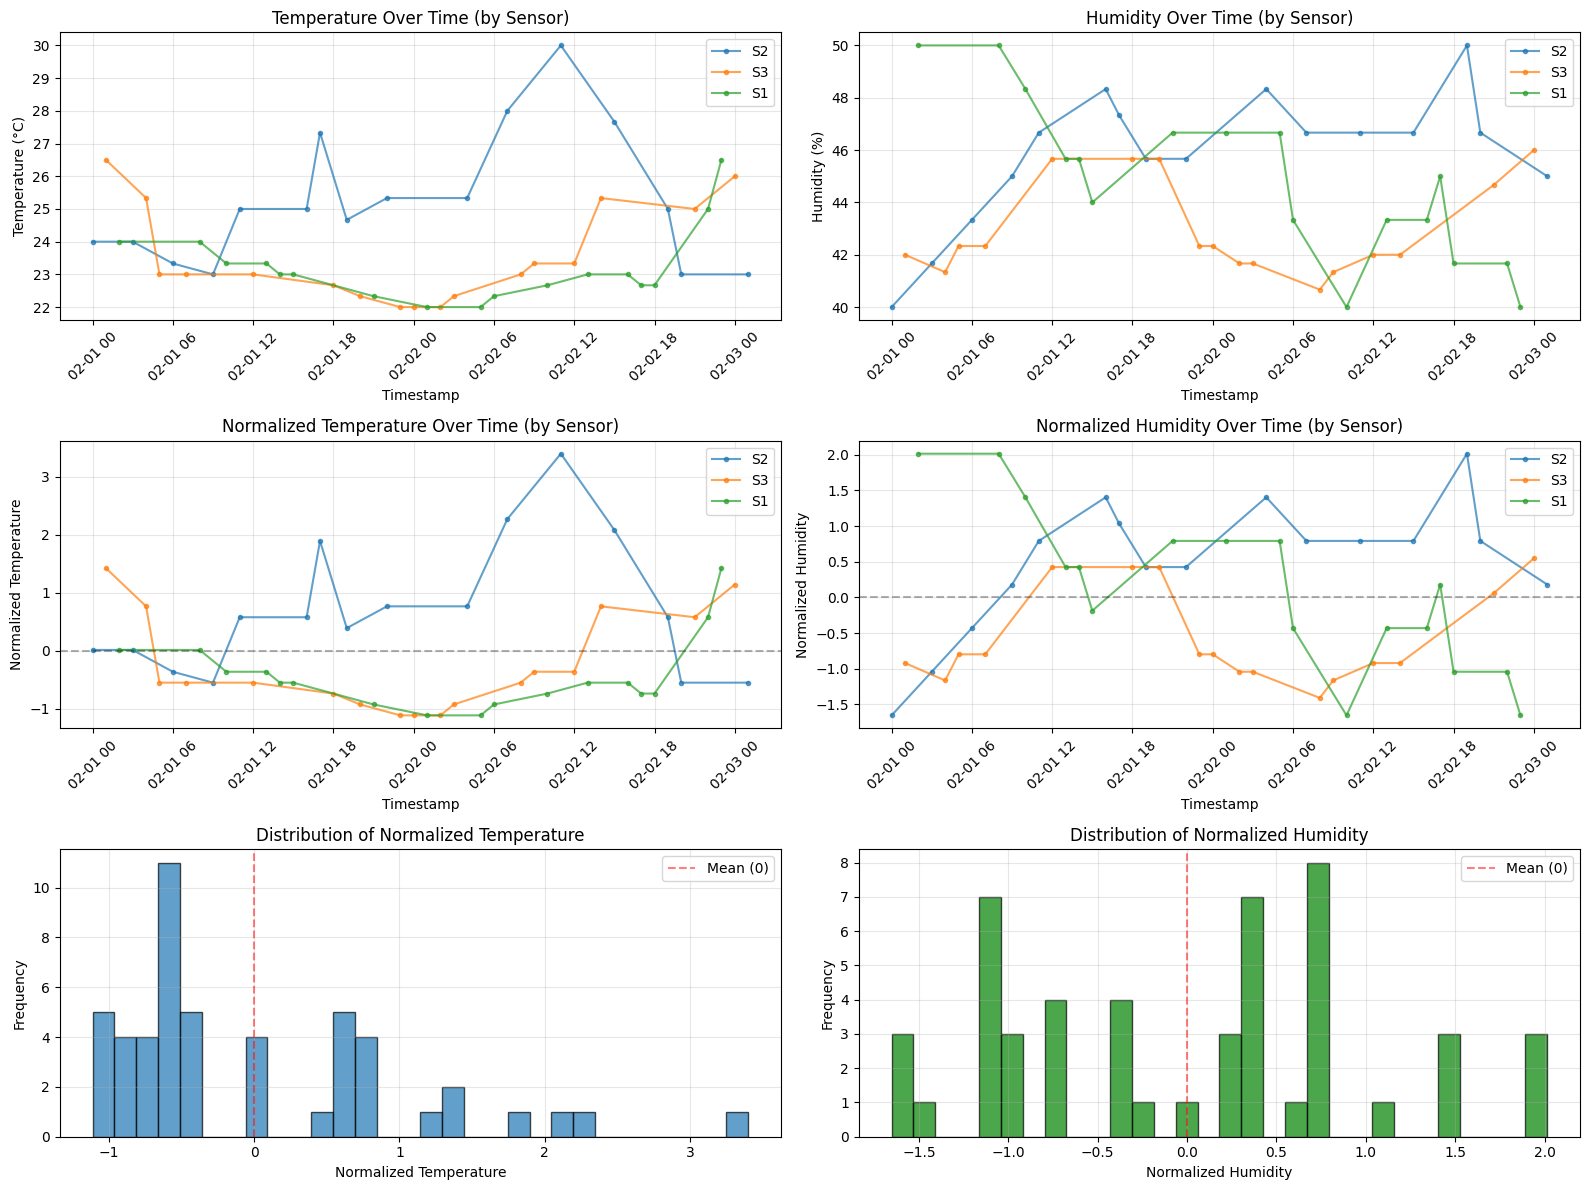

In [18]:
# Visualize the preprocessed dataset
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Plot 1: Temperature over time (by sensor)
for sensor_id in final_dataset['sensor_id'].unique():
    sensor_data = final_dataset[final_dataset['sensor_id'] == sensor_id]
    axes[0, 0].plot(sensor_data['timestamp'], sensor_data['temperature'], 
                    label=f'{sensor_id}', marker='o', markersize=3, alpha=0.7)
axes[0, 0].set_title('Temperature Over Time (by Sensor)')
axes[0, 0].set_xlabel('Timestamp')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Humidity over time (by sensor)
for sensor_id in final_dataset['sensor_id'].unique():
    sensor_data = final_dataset[final_dataset['sensor_id'] == sensor_id]
    axes[0, 1].plot(sensor_data['timestamp'], sensor_data['humidity'], 
                    label=f'{sensor_id}', marker='o', markersize=3, alpha=0.7)
axes[0, 1].set_title('Humidity Over Time (by Sensor)')
axes[0, 1].set_xlabel('Timestamp')
axes[0, 1].set_ylabel('Humidity (%)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Normalized Temperature over time (by sensor)
for sensor_id in final_dataset['sensor_id'].unique():
    sensor_data = final_dataset[final_dataset['sensor_id'] == sensor_id]
    axes[1, 0].plot(sensor_data['timestamp'], sensor_data['temperature_normalized'], 
                    label=f'{sensor_id}', marker='o', markersize=3, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 0].set_title('Normalized Temperature Over Time (by Sensor)')
axes[1, 0].set_xlabel('Timestamp')
axes[1, 0].set_ylabel('Normalized Temperature')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Normalized Humidity over time (by sensor)
for sensor_id in final_dataset['sensor_id'].unique():
    sensor_data = final_dataset[final_dataset['sensor_id'] == sensor_id]
    axes[1, 1].plot(sensor_data['timestamp'], sensor_data['humidity_normalized'], 
                    label=f'{sensor_id}', marker='o', markersize=3, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1, 1].set_title('Normalized Humidity Over Time (by Sensor)')
axes[1, 1].set_xlabel('Timestamp')
axes[1, 1].set_ylabel('Normalized Humidity')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Distribution of normalized temperature
axes[2, 0].hist(final_dataset['temperature_normalized'], bins=30, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Mean (0)')
axes[2, 0].set_title('Distribution of Normalized Temperature')
axes[2, 0].set_xlabel('Normalized Temperature')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Distribution of normalized humidity
axes[2, 1].hist(final_dataset['humidity_normalized'], bins=30, alpha=0.7, edgecolor='black', color='green')
axes[2, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Mean (0)')
axes[2, 1].set_title('Distribution of Normalized Humidity')
axes[2, 1].set_xlabel('Normalized Humidity')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


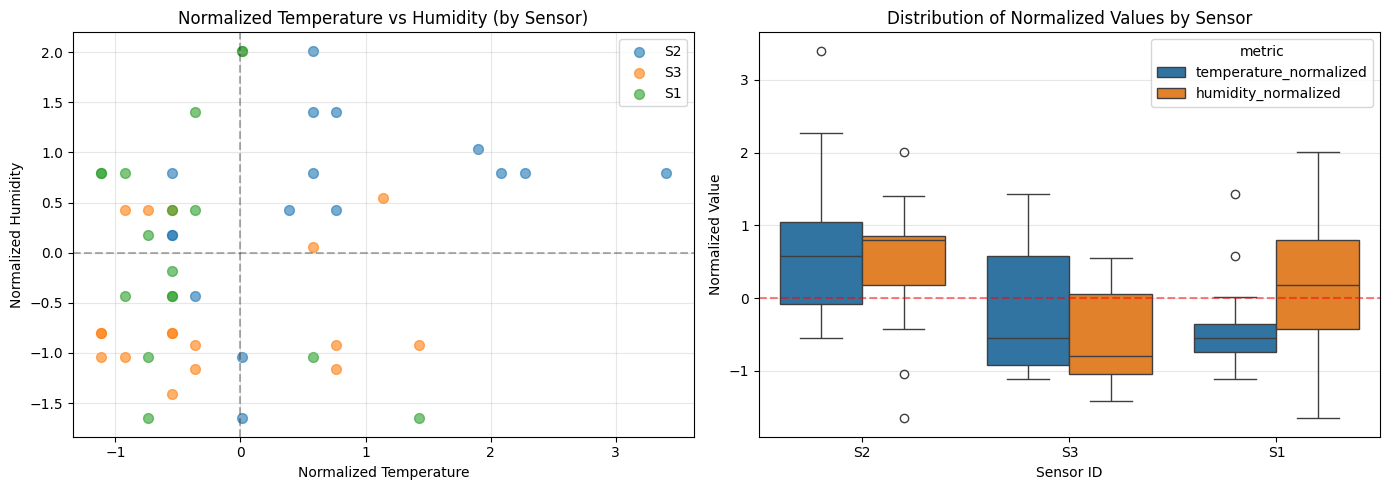

In [19]:
# Additional visualization: Scatter plot for anomaly detection preparation
# This helps identify potential anomalies in the normalized feature space

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot: Normalized Temperature vs Normalized Humidity (colored by sensor)
for sensor_id in final_dataset['sensor_id'].unique():
    sensor_data = final_dataset[final_dataset['sensor_id'] == sensor_id]
    axes[0].scatter(sensor_data['temperature_normalized'], sensor_data['humidity_normalized'], 
                    label=f'{sensor_id}', alpha=0.6, s=50)
axes[0].set_title('Normalized Temperature vs Humidity (by Sensor)')
axes[0].set_xlabel('Normalized Temperature')
axes[0].set_ylabel('Normalized Humidity')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3)

# Box plot: Normalized values by sensor (helps identify sensor-specific anomalies)
normalized_data = pd.melt(final_dataset, 
                          id_vars=['sensor_id'],
                          value_vars=['temperature_normalized', 'humidity_normalized'],
                          var_name='metric', value_name='normalized_value')
sns.boxplot(data=normalized_data, x='sensor_id', y='normalized_value', hue='metric', ax=axes[1])
axes[1].set_title('Distribution of Normalized Values by Sensor')
axes[1].set_xlabel('Sensor ID')
axes[1].set_ylabel('Normalized Value')
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [20]:
# Save the cleaned dataset to CSV
output_filename = 'iot_sensor_cleaned.csv'
final_dataset.to_csv(output_filename, index=False)
print(f"Cleaned dataset saved to '{output_filename}'")
print(f"\nDataset is ready for anomaly detection!")
print(f"\nFeatures available for anomaly detection:")
print("  - timestamp: Time index for temporal analysis")
print("  - sensor_id: Original sensor identifier")
print("  - sensor_id_encoded: Numerically encoded sensor ID")
print("  - temperature: Original temperature (smoothed)")
print("  - humidity: Original humidity (smoothed)")
print("  - temperature_normalized: Standard-scaled temperature (mean=0, std=1)")
print("  - humidity_normalized: Standard-scaled humidity (mean=0, std=1)")
print(f"\nRecommended features for anomaly detection:")
print("  - Use 'temperature_normalized' and 'humidity_normalized' for ML models")
print("  - Use 'sensor_id_encoded' as a categorical feature")
print("  - Consider temporal features (hour, day, etc.) derived from 'timestamp'")
print(f"\nPreprocessing steps completed:")
print("  ✓ Missing values handled (forward fill)")
print("  ✓ Sensor drift removed (rolling mean smoothing)")
print("  ✓ Temperature and humidity normalized (standard scaling)")
print("  ✓ Categorical sensor IDs encoded")


Cleaned dataset saved to 'iot_sensor_cleaned.csv'

Dataset is ready for anomaly detection!

Features available for anomaly detection:
  - timestamp: Time index for temporal analysis
  - sensor_id: Original sensor identifier
  - sensor_id_encoded: Numerically encoded sensor ID
  - temperature: Original temperature (smoothed)
  - humidity: Original humidity (smoothed)
  - temperature_normalized: Standard-scaled temperature (mean=0, std=1)
  - humidity_normalized: Standard-scaled humidity (mean=0, std=1)

Recommended features for anomaly detection:
  - Use 'temperature_normalized' and 'humidity_normalized' for ML models
  - Use 'sensor_id_encoded' as a categorical feature
  - Consider temporal features (hour, day, etc.) derived from 'timestamp'

Preprocessing steps completed:
  ✓ Missing values handled (forward fill)
  ✓ Sensor drift removed (rolling mean smoothing)
  ✓ Temperature and humidity normalized (standard scaling)
  ✓ Categorical sensor IDs encoded
